Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 60%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.0247148s, CPU 0.024621s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0331201s, CPU 0.033151s)
Info    : 373 nodes 748 elements
Triangle 3


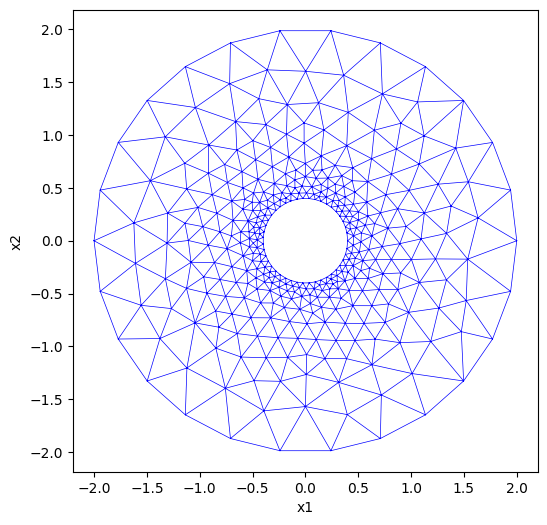

In [3]:
import meshBuilder
import matplotlib.pyplot as plt

mesh0, b0 = meshBuilder.buildMesh_tri_cylinder_gmsh(
    x0=[0, 0],
    r_inner=0.4,
    r_outer=2,
    lc=0.5,
    lc_inner=0.05
)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
p = mesh0.plot_grid(ax=ax, linewidth=0.5, color="b")


/home/harry/projects/chimeraTreeDemo/chimeraTreeDemo/meshBuilder.py:19: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  mesh = TreeMesh([hx, hy], x0="CC")


(-2.0, 2.0)

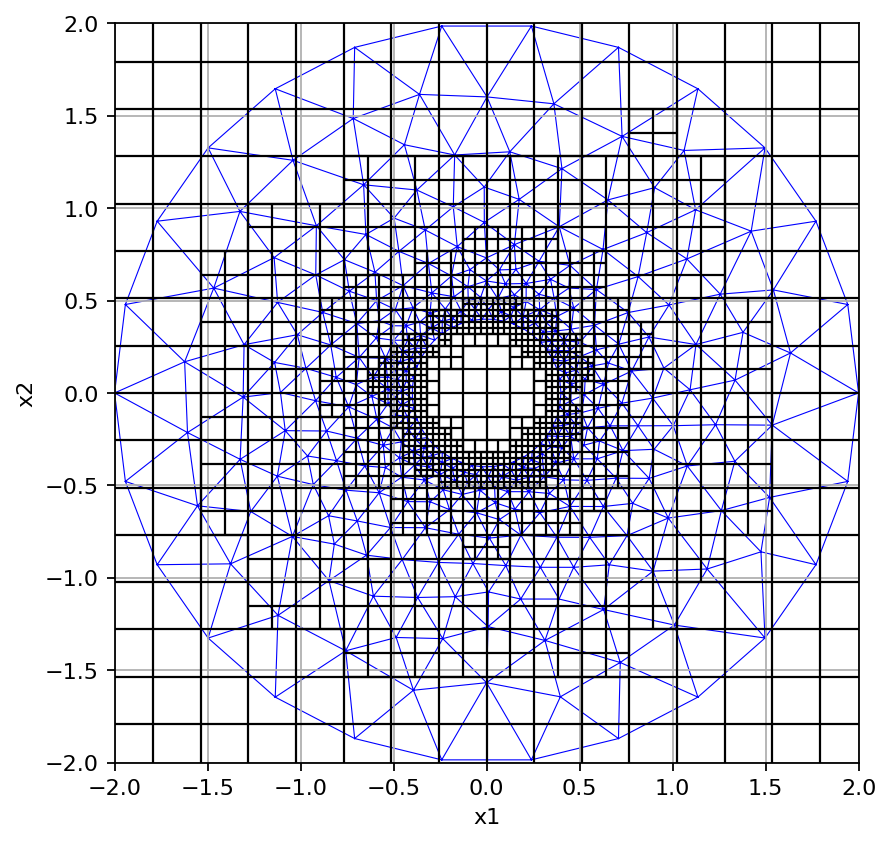

In [12]:
cents = mesh0.cell_centers
import meshHelper

Ls = meshHelper.get_max_edge_length(mesh0)
LsAABB = meshHelper.get_max_AABB_length(mesh0)

h0 = 0.001
meshB, nLevel = meshBuilder.buildMesh_quadTree(h0, h0, 100, 100)
meshB.refine_ball(
    cents, Ls * 1, meshHelper.get_level(LsAABB, nLevel, h0), finalize=False
)

meshB.finalize()

fig = plt.figure(figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111)
meshB.plot_grid(ax=ax, color="k", linewidth=1.0)
mesh0.plot_grid(ax=ax, color="b", linewidth=0.5)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])